# Multiple Linear Regression

In [104]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

az.style.use('arviz-darkgrid')
#import seaborn as sns
#sns.set()

## Load raw data and plot

In [105]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/coffee/FTIR_instant_coffee.csv')
data.head(2)

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code,label
0,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,1,Arabica
1,10.364243,10.569554,10.448875,10.100696,9.620371,8.882499,8.415529,8.210217,7.916430,7.806151,...,1.493133,1.475563,1.464682,1.456444,1.442087,1.433698,1.425288,1.418705,1,Arabica


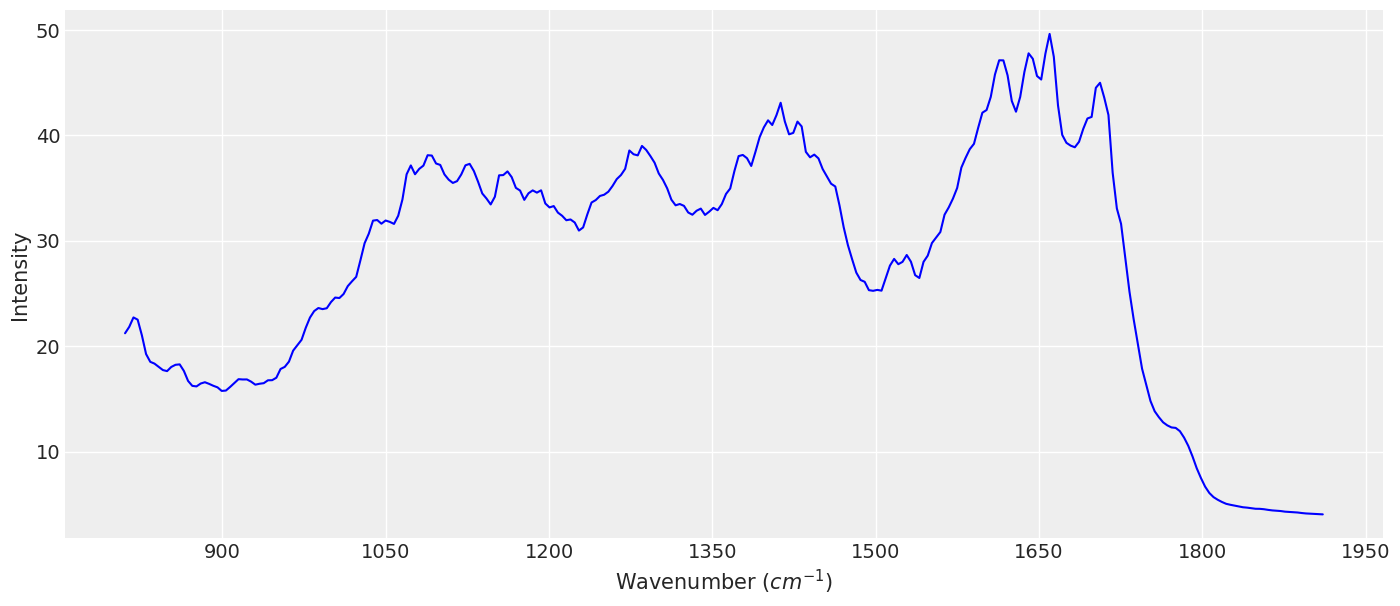

In [106]:
# header data = x-values
cols = data.columns.to_list()
x_str = cols[:-2]
x_val = np.array(x_str, dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(17,7))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity')

y = data.values[0]
y_val = y[:-2]
plt.plot(x_val, y_val, '-', color='blue');

In [107]:
# center x-values around x = 0
def zero_center(X):
    return X - np.mean(X, axis=0)

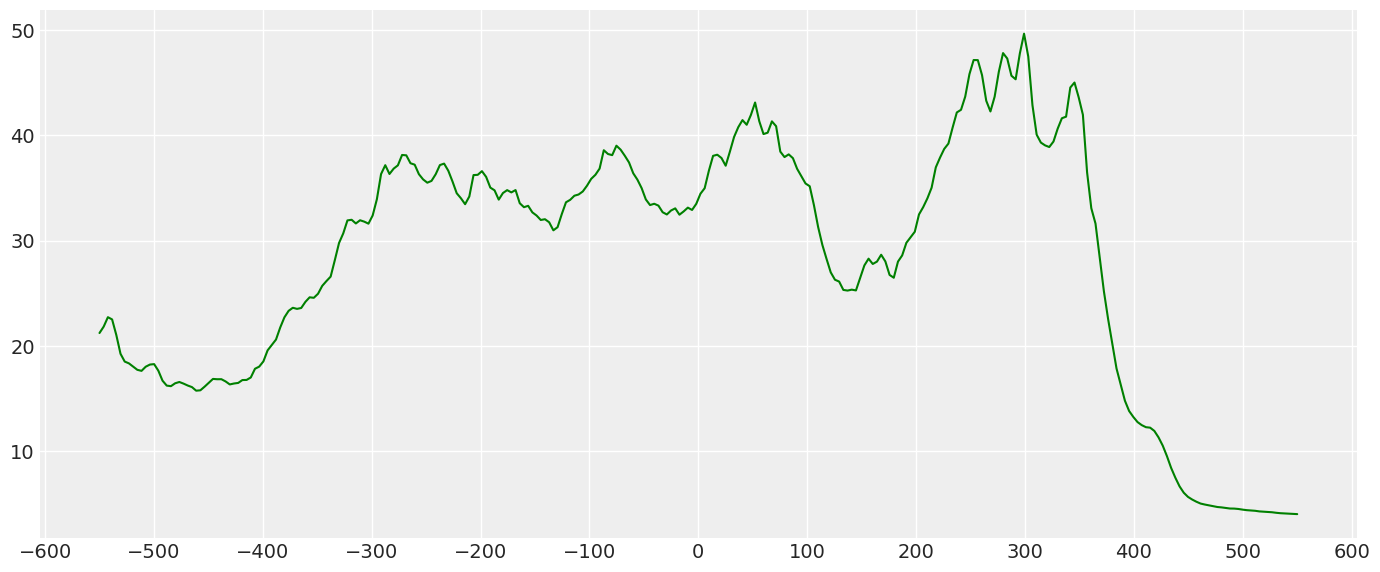

In [109]:
# convert x-values to float32 type, center and plot
x_zero = zero_center(np.array(x_val, dtype='float32'))

fig = plt.figure(figsize=(17,7))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(15))

y = data.values[0]
y_val = y[:-2]
plt.plot(x_zero, y_val, '-', color='green');

## Model definition

In [110]:
x = np.array(x_val, dtype='float32')
x_mean = x.mean(axis=0, keepdims=True)

In [116]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=len(x_zero))
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha_tmp + pm.math.dot(x_zero, beta)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(x_mean, beta))

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_val)

    trace_mlr = pm.sample(200)

ValueError: shapes (1,) and (286,) not aligned: 1 (dim 0) != 286 (dim 0)

In [112]:
az.summary(trace_mlr)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_tmp,1.211,1.555,-1.564,4.292,0.878,0.721,3.0,3.0,3.0,12.0,2.64
beta[0],-0.173,0.613,-0.934,0.431,0.421,0.352,2.0,2.0,3.0,11.0,2.14
beta[1],0.466,0.218,0.020,0.620,0.108,0.083,4.0,4.0,4.0,26.0,1.84
beta[2],-0.454,0.338,-1.322,-0.143,0.211,0.170,3.0,3.0,3.0,15.0,2.35
beta[3],-0.715,0.349,-1.131,0.078,0.155,0.117,5.0,5.0,7.0,16.0,1.86
beta[4],-0.456,0.662,-1.738,0.991,0.359,0.280,3.0,3.0,4.0,21.0,2.03
beta[5],-0.006,0.642,-0.798,0.625,0.442,0.370,2.0,2.0,2.0,14.0,2.90
beta[6],-0.220,0.084,-0.337,-0.021,0.031,0.023,7.0,7.0,12.0,21.0,1.83
beta[7],-0.326,0.698,-1.921,1.093,0.123,0.176,32.0,8.0,24.0,44.0,2.08
beta[8],-0.024,0.817,-1.007,0.785,0.564,0.473,2.0,2.0,3.0,15.0,2.07


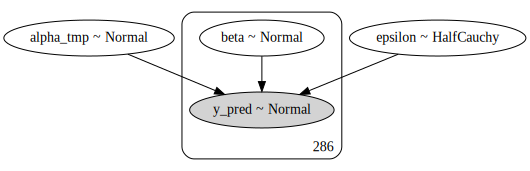

In [113]:
pm.model_to_graphviz(model_mlr)

In [114]:
ppc = pm.sample_posterior_predictive(trace_mlr, samples=200, model=model_mlr, random_seed=2)

100%|██████████| 200/200 [00:00<00:00, 771.82it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


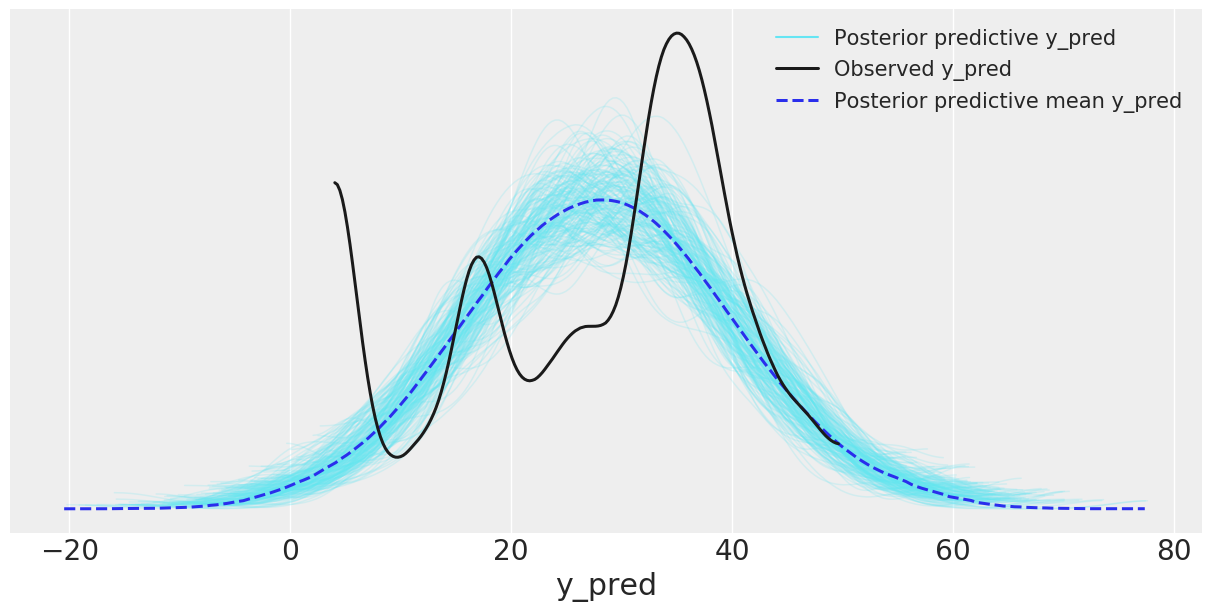

In [115]:
data_ppc = az.from_pymc3(trace=trace_mlr, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)